<img src="images/image.jpg">

# We will try to guess the price of apartment based on some French data

### First, let's import the good libraries 

In [92]:
import pandas as pd
import requests
import seaborn as sn
import numpy as np
from numpy import mean
from numpy import std
import sklearn
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance
from pandas_profiling import ProfileReport
from sklearn.feature_selection import SelectKBest
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
import pymc3 as pm
from sklearn.feature_selection import RFE
import PipelineProfiler
from sklearn.model_selection import StratifiedKFold
from pymc3 import traceplot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import autosklearn.regression
import pickle
from autosklearn.metrics import mean_absolute_error as auto_mean_absolute_error
from autosklearn.metrics import mean_squared_error as auto_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFECV
from tpot import TPOTRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


## Let's read the data

In [183]:
data_brut = pd.read_csv('./data.csv')
data_brut.head()

,Unnamed: 0,type_appartement,nombre_pièces,nombre_chambres,surface,étage,terasse,ascenceur,prix_achat,credit,localisation,description
0,0,Appartement,4,2.0,104.0,NaN,non défini,non défini,499000,2065,Lyon 3ème,La Guillotière Nord
1,1,Appartement,3,2.0,72.0,NaN,non défini,non défini,449505,1861,Lyon 1er,Terreaux
2,2,Appartement,5,4.0,99.0,NaN,non défini,non défini,410000,1699,Lyon 8ème,Transvaal
3,3,Appartement,3,2.0,61.0,NaN,non défini,non défini,437000,1810,Lyon 6ème,Les Brotteaux-Bellecombe-Masséna
4,4,Appartement,4,3.0,129.0,NaN,non défini,non défini,725000,2997,Lyon 7ème,CHARME DE L'ANCIEN pour cet appartement de 129...


In [184]:
data_brut.describe()

,Unnamed: 0,nombre_pièces,nombre_chambres,surface,étage,prix_achat
count,3255.00000,3255.000000,2879.000000,3238.000000,104.000000,3.255000e+03
mean,1627.00000,3.231951,2.346995,80.328752,4.259615,4.823640e+05
std,939.78189,1.368479,1.044917,42.748161,1.762584,3.285089e+05
min,0.00000,1.000000,1.000000,7.000000,1.000000,4.500000e+04
25%,813.50000,2.000000,2.000000,53.000000,3.000000,2.750000e+05
50%,1627.00000,3.000000,2.000000,75.000000,4.500000,3.990000e+05
75%,2440.50000,4.000000,3.000000,99.000000,5.000000,5.950000e+05
max,3254.00000,10.000000,14.000000,364.000000,10.000000,3.300000e+06


We can see that etage have a lot of Nan value

In [185]:
data_brut.isna().sum()

Unnamed: 0             0
type_appartement       0
nombre_pièces          0
nombre_chambres      376
surface               17
étage               3151
terasse                0
ascenceur              0
prix_achat             0
credit                 0
localisation           0
description            0
dtype: int64

In [186]:
data_brut['localisation'].unique()

array(['Lyon 3ème', 'Lyon 1er', 'Lyon 8ème', 'Lyon 6ème', 'Lyon 7ème',
       'Lyon 9ème', 'Lyon 4ème', 'Lyon 2ème', 'Lyon 5ème',
       'Rillieux-la-Pape', 'Tassin-la-Demi-Lune', 'Écully',
       'Contenu sponsorisé', 'Villeurbanne'], dtype=object)

In [187]:
data_brut = data_brut[data_brut['localisation'] != 'Contenu sponsorisé']
data_brut['localisation'].unique()

array(['Lyon 3ème', 'Lyon 1er', 'Lyon 8ème', 'Lyon 6ème', 'Lyon 7ème',
       'Lyon 9ème', 'Lyon 4ème', 'Lyon 2ème', 'Lyon 5ème',
       'Rillieux-la-Pape', 'Tassin-la-Demi-Lune', 'Écully',
       'Villeurbanne'], dtype=object)

In [188]:
data_brut['type_appartement'].unique()

array(['Appartement'], dtype=object)

In [189]:
data_brut.loc[data_brut['type_appartement'] == 'Appartement', 'type_appartement'] = np.nan
data_brut

,Unnamed: 0,type_appartement,nombre_pièces,nombre_chambres,surface,étage,terasse,ascenceur,prix_achat,credit,localisation,description
0,0,NaN,4,2.0,104.0,NaN,non défini,non défini,499000,2065,Lyon 3ème,La Guillotière Nord
1,1,NaN,3,2.0,72.0,NaN,non défini,non défini,449505,1861,Lyon 1er,Terreaux
2,2,NaN,5,4.0,99.0,NaN,non défini,non défini,410000,1699,Lyon 8ème,Transvaal
3,3,NaN,3,2.0,61.0,NaN,non défini,non défini,437000,1810,Lyon 6ème,Les Brotteaux-Bellecombe-Masséna
4,4,NaN,4,3.0,129.0,NaN,non défini,non défini,725000,2997,Lyon 7ème,CHARME DE L'ANCIEN pour cet appartement de 129...
...,...,...,...,...,...,...,...,...,...,...,...,...
3250,3250,NaN,6,5.0,218.0,NaN,non défini,non défini,1750000,7220,Lyon 2ème,Perrache-Le Confluent
3251,3251,NaN,4,3.0,87.0,NaN,non défini,non défini,420000,1740,Écully,Le-Perollier
3252,3252,NaN,3,2.0,69.0,NaN,non défini,non défini,420000,1740,Lyon 6ème,Les Brotteaux-Bellecombe-Masséna
3253,3253,NaN,4,3.0,86.0,NaN,non défini,non défini,417000,1727,Lyon 3ème,Villette


In [190]:
data_brut['terasse'].unique()

array(['non défini', '1'], dtype=object)

In [191]:
data_brut.loc[data_brut['terasse'] == 'non défini', 'terasse'] = np.nan
data_brut

,Unnamed: 0,type_appartement,nombre_pièces,nombre_chambres,surface,étage,terasse,ascenceur,prix_achat,credit,localisation,description
0,0,NaN,4,2.0,104.0,NaN,NaN,non défini,499000,2065,Lyon 3ème,La Guillotière Nord
1,1,NaN,3,2.0,72.0,NaN,NaN,non défini,449505,1861,Lyon 1er,Terreaux
2,2,NaN,5,4.0,99.0,NaN,NaN,non défini,410000,1699,Lyon 8ème,Transvaal
3,3,NaN,3,2.0,61.0,NaN,NaN,non défini,437000,1810,Lyon 6ème,Les Brotteaux-Bellecombe-Masséna
4,4,NaN,4,3.0,129.0,NaN,NaN,non défini,725000,2997,Lyon 7ème,CHARME DE L'ANCIEN pour cet appartement de 129...
...,...,...,...,...,...,...,...,...,...,...,...,...
3250,3250,NaN,6,5.0,218.0,NaN,NaN,non défini,1750000,7220,Lyon 2ème,Perrache-Le Confluent
3251,3251,NaN,4,3.0,87.0,NaN,NaN,non défini,420000,1740,Écully,Le-Perollier
3252,3252,NaN,3,2.0,69.0,NaN,NaN,non défini,420000,1740,Lyon 6ème,Les Brotteaux-Bellecombe-Masséna
3253,3253,NaN,4,3.0,86.0,NaN,NaN,non défini,417000,1727,Lyon 3ème,Villette


In [192]:
data_brut['ascenceur'].unique()

array(['non défini', 'oui'], dtype=object)

In [193]:
data_brut.loc[data_brut['ascenceur'] == 'non défini', 'ascenceur'] = np.nan
data_brut

,Unnamed: 0,type_appartement,nombre_pièces,nombre_chambres,surface,étage,terasse,ascenceur,prix_achat,credit,localisation,description
0,0,NaN,4,2.0,104.0,NaN,NaN,NaN,499000,2065,Lyon 3ème,La Guillotière Nord
1,1,NaN,3,2.0,72.0,NaN,NaN,NaN,449505,1861,Lyon 1er,Terreaux
2,2,NaN,5,4.0,99.0,NaN,NaN,NaN,410000,1699,Lyon 8ème,Transvaal
3,3,NaN,3,2.0,61.0,NaN,NaN,NaN,437000,1810,Lyon 6ème,Les Brotteaux-Bellecombe-Masséna
4,4,NaN,4,3.0,129.0,NaN,NaN,NaN,725000,2997,Lyon 7ème,CHARME DE L'ANCIEN pour cet appartement de 129...
...,...,...,...,...,...,...,...,...,...,...,...,...
3250,3250,NaN,6,5.0,218.0,NaN,NaN,NaN,1750000,7220,Lyon 2ème,Perrache-Le Confluent
3251,3251,NaN,4,3.0,87.0,NaN,NaN,NaN,420000,1740,Écully,Le-Perollier
3252,3252,NaN,3,2.0,69.0,NaN,NaN,NaN,420000,1740,Lyon 6ème,Les Brotteaux-Bellecombe-Masséna
3253,3253,NaN,4,3.0,86.0,NaN,NaN,NaN,417000,1727,Lyon 3ème,Villette


In [194]:
data_brut.isna().sum()

Unnamed: 0             0
type_appartement    3245
nombre_pièces          0
nombre_chambres      376
surface               17
étage               3141
terasse             3227
ascenceur           3055
prix_achat             0
credit                 0
localisation           0
description            0
dtype: int64

<AxesSubplot:>

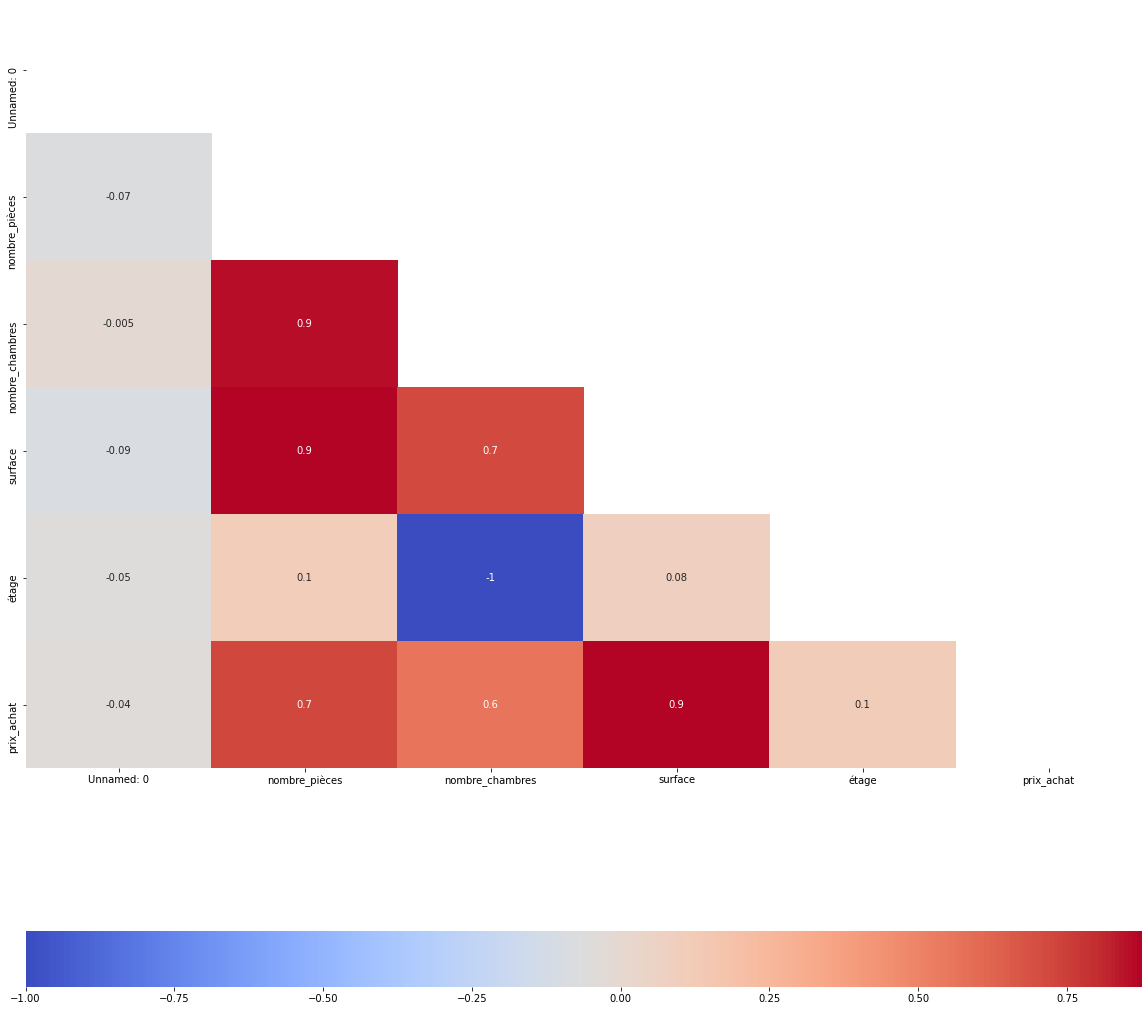

In [195]:
plt.figure(figsize=(20,20))
corr_matrix = data_brut.corr()
sn.heatmap(corr_matrix, annot=True, fmt='.1g', cmap= 'coolwarm' , mask = np.triu(corr_matrix), cbar_kws= {'orientation': 'horizontal'})
#plt.show()

Conclusion : 
- Descirption is too various
- Localsiation ok 
- Credit i don't know what it is
- prix d'achat : output variable to predict
- ascenceur too much Nan
- terasse too much Nan
- etage too much Nan
- surface ok 
- nb chambres ok because it is not too corelated with surface
- nb peices too corelated with surface

## Preapre the data even if we already begun hahahaahahahahahahaahh !

#### Take off the useless column

In [196]:
data_brut.columns

Index(['Unnamed: 0', 'type_appartement', 'nombre_pièces', 'nombre_chambres',
       'surface', 'étage', 'terasse', 'ascenceur', 'prix_achat', 'credit',
       'localisation', 'description'],
      dtype='object')

In [197]:
choosed_column = ['nombre_chambres', 'surface', 'prix_achat', 'localisation']

In [198]:
data_selct = data_brut[choosed_column]
data_selct.head()

,nombre_chambres,surface,prix_achat,localisation
0,2.0,104.0,499000,Lyon 3ème
1,2.0,72.0,449505,Lyon 1er
2,4.0,99.0,410000,Lyon 8ème
3,2.0,61.0,437000,Lyon 6ème
4,3.0,129.0,725000,Lyon 7ème


In [199]:
data_selct['localisation'].unique()

array(['Lyon 3ème', 'Lyon 1er', 'Lyon 8ème', 'Lyon 6ème', 'Lyon 7ème',
       'Lyon 9ème', 'Lyon 4ème', 'Lyon 2ème', 'Lyon 5ème',
       'Rillieux-la-Pape', 'Tassin-la-Demi-Lune', 'Écully',
       'Villeurbanne'], dtype=object)

In [200]:
di = {'Lyon 3ème': "Lyon3", 'Lyon 1er' : "Lyon1", 'Lyon 8ème' : "Lyon8", 'Lyon 6ème' : 'Lyon6', 'Lyon 7ème' : 'Lyon7', 'Lyon 9ème' : 'Lyon9', 'Lyon 4ème' : 'Lyon4', 'Lyon 2ème' : 'Lyon2', 'Lyon 5ème' : 'Lyon5', 'Rillieux-la-Pape' : 'Périphérie', 'Tassin-la-Demi-Lune' : 'Périphérie', 'Écully' : 'Périphérie', 'Villeurbanne' : 'Périphérie' }

In [201]:
data_selct['localisation'].replace(di, inplace = True)

/home/yann/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [202]:
data_selct.head()

,nombre_chambres,surface,prix_achat,localisation
0,2.0,104.0,499000,Lyon3
1,2.0,72.0,449505,Lyon1
2,4.0,99.0,410000,Lyon8
3,2.0,61.0,437000,Lyon6
4,3.0,129.0,725000,Lyon7


In [203]:
data_selct.describe()

,nombre_chambres,surface,prix_achat
count,2869.000000,3228.000000,3.245000e+03
mean,2.348902,80.393123,4.829525e+05
std,1.045971,42.796273,3.288190e+05
min,1.000000,7.000000,4.500000e+04
25%,2.000000,53.000000,2.750000e+05
50%,2.000000,75.000000,3.990000e+05
75%,3.000000,99.000000,5.950000e+05
max,14.000000,364.000000,3.300000e+06


In [204]:
data_selct[data_selct.isna().any(axis=1)]

,nombre_chambres,surface,prix_achat,localisation
90,NaN,26.0,159500,Lyon1
96,NaN,19.0,98000,Lyon7
98,NaN,18.0,108000,Lyon5
107,NaN,20.0,144200,Lyon9
108,NaN,26.0,154500,Lyon9
...,...,...,...,...
3213,NaN,26.0,299000,Lyon1
3214,NaN,31.0,234000,Lyon5
3223,NaN,40.0,270000,Lyon6
3225,4.0,NaN,290000,Lyon5


In [205]:
data_selct = data_selct[data_selct['surface'].notnull()]
len(data_selct)

3228

With a mean of the surface of 26 I guess that it is a studio

In [206]:
df_nan = data_selct[data_selct.isna().any(axis=1)]
df_nan.describe()

,nombre_chambres,surface,prix_achat
count,0.0,374.000000,374.000000
mean,NaN,26.454545,172860.796791
std,NaN,15.608543,96121.068792
min,NaN,7.000000,45000.000000
25%,NaN,18.000000,112000.000000
50%,NaN,22.000000,168000.000000
75%,NaN,30.000000,210000.000000
max,NaN,135.000000,899000.000000


In [207]:
df_nan_absurdo = df_nan[df_nan['surface'] > 50]
len(df_nan_absurdo)

16

In [208]:
df_nan_absurdo

,nombre_chambres,surface,prix_achat,localisation
169,NaN,135.0,897000,Lyon6
316,NaN,63.0,331000,Lyon6
373,NaN,73.0,315000,Lyon1
1269,NaN,85.0,535563,Lyon1
1866,NaN,51.0,265000,Lyon7
1870,NaN,85.0,435000,Lyon4
1899,NaN,62.0,439000,Lyon1
2236,NaN,71.0,495000,Lyon3
2382,NaN,119.0,599000,Lyon9
2422,NaN,90.0,450000,Lyon1


In [209]:
df_prep = pd.concat([data_selct, df_nan_absurdo]).drop_duplicates(keep=False)
df_prep

,nombre_chambres,surface,prix_achat,localisation
8,3.0,150.0,749000,Lyon9
9,3.0,93.0,345000,Lyon8
10,1.0,47.0,339000,Lyon1
11,3.0,94.0,494400,Lyon4
13,3.0,81.0,364000,Lyon3
...,...,...,...,...
3228,1.0,55.0,507720,Lyon2
3229,2.0,71.0,365000,Lyon7
3230,2.0,62.0,328000,Lyon9
3231,5.0,220.0,1485000,Lyon2


In [210]:
df_prep.fillna(value=0.5,inplace=True)

In [211]:
df_prep['nombre_chambres'].unique()

array([ 3. ,  1. ,  2. ,  5. ,  4. ,  0.5,  6. ,  7. , 11. , 14. ])

In [212]:
df_prep

,nombre_chambres,surface,prix_achat,localisation
8,3.0,150.0,749000,Lyon9
9,3.0,93.0,345000,Lyon8
10,1.0,47.0,339000,Lyon1
11,3.0,94.0,494400,Lyon4
13,3.0,81.0,364000,Lyon3
...,...,...,...,...
3228,1.0,55.0,507720,Lyon2
3229,2.0,71.0,365000,Lyon7
3230,2.0,62.0,328000,Lyon9
3231,5.0,220.0,1485000,Lyon2


Text(0, 0.5, 'Prix')

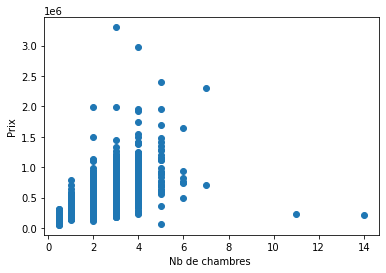

In [213]:
plt.scatter(df_prep['nombre_chambres'], df_prep['prix_achat'])
plt.xlabel('Nb de chambres ')
plt.ylabel('Prix')


Text(0, 0.5, 'Prix')

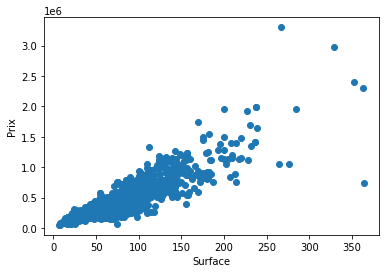

In [214]:
plt.scatter(df_prep['surface'], df_prep['prix_achat'])
plt.xlabel('Surface')
plt.ylabel('Prix')


### take off the outlier

In [215]:
df_surface_absurdo = df_prep[df_prep['surface']>250]
df_surface_absurdo

,nombre_chambres,surface,prix_achat,localisation
788,3.0,265.0,1050000,Lyon4
1074,5.0,352.0,2400000,Lyon2
1105,6.0,364.0,734000,Lyon8
1239,5.0,285.0,1950000,Lyon3
1827,3.0,267.0,3300000,Lyon6
2507,4.0,329.0,2980000,Lyon2
2854,7.0,363.0,2300000,Lyon4
3007,3.0,276.0,1050000,Lyon4


In [216]:
df_chambre_absurdo = df_prep[df_prep['nombre_chambres']>10]
df_chambre_absurdo

,nombre_chambres,surface,prix_achat,localisation
3109,11.0,44.0,229900,Lyon9
3166,14.0,44.0,222900,Lyon9


In [217]:
df = pd.concat([df_prep, df_surface_absurdo]).drop_duplicates(keep=False)
df

,nombre_chambres,surface,prix_achat,localisation
8,3.0,150.0,749000,Lyon9
9,3.0,93.0,345000,Lyon8
10,1.0,47.0,339000,Lyon1
11,3.0,94.0,494400,Lyon4
13,3.0,81.0,364000,Lyon3
...,...,...,...,...
3228,1.0,55.0,507720,Lyon2
3229,2.0,71.0,365000,Lyon7
3230,2.0,62.0,328000,Lyon9
3231,5.0,220.0,1485000,Lyon2


In [218]:
df = pd.concat([df, df_chambre_absurdo]).drop_duplicates(keep=False)
df

,nombre_chambres,surface,prix_achat,localisation
8,3.0,150.0,749000,Lyon9
9,3.0,93.0,345000,Lyon8
10,1.0,47.0,339000,Lyon1
11,3.0,94.0,494400,Lyon4
13,3.0,81.0,364000,Lyon3
...,...,...,...,...
3228,1.0,55.0,507720,Lyon2
3229,2.0,71.0,365000,Lyon7
3230,2.0,62.0,328000,Lyon9
3231,5.0,220.0,1485000,Lyon2


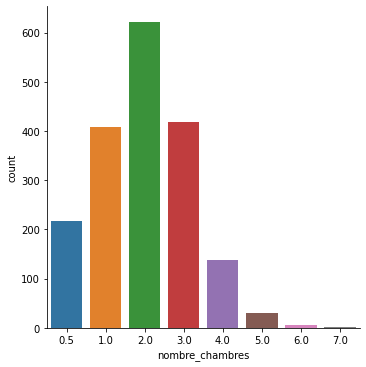

In [219]:
sns.catplot(x='nombre_chambres', kind='count', data=df)

<AxesSubplot:>

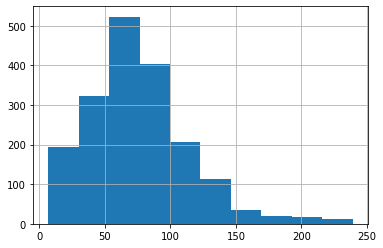

In [220]:
df['surface'].hist(bins = 10)

/home/yann/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


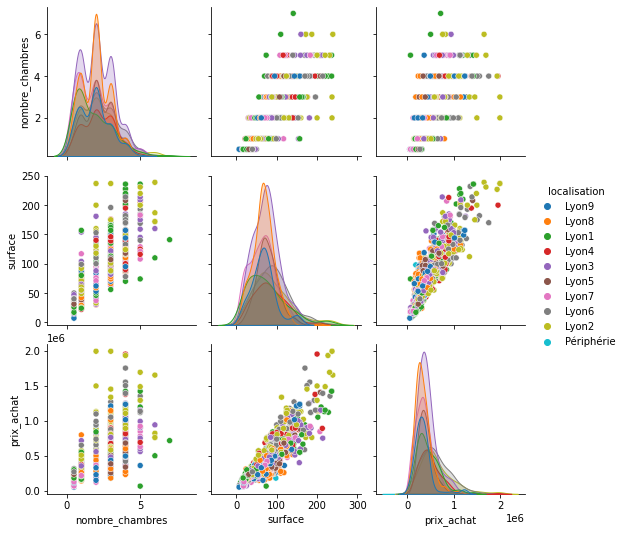

In [221]:
sns.pairplot(df,hue='localisation')

In [222]:
df.groupby('nombre_chambres').count()


,surface,prix_achat,localisation
nombre_chambres,,,
0.5,218,218,218
1.0,408,408,408
2.0,622,622,622
3.0,418,418,418
4.0,138,138,138
5.0,31,31,31
6.0,6,6,6
7.0,1,1,1


In [223]:
df.to_pickle("dataframe.pickle")

In [224]:
df.dtypes

nombre_chambres    float64
surface            float64
prix_achat           int64
localisation        object
dtype: object

# Train a model

In [225]:
df

,nombre_chambres,surface,prix_achat,localisation
8,3.0,150.0,749000,Lyon9
9,3.0,93.0,345000,Lyon8
10,1.0,47.0,339000,Lyon1
11,3.0,94.0,494400,Lyon4
13,3.0,81.0,364000,Lyon3
...,...,...,...,...
3228,1.0,55.0,507720,Lyon2
3229,2.0,71.0,365000,Lyon7
3230,2.0,62.0,328000,Lyon9
3231,5.0,220.0,1485000,Lyon2


In [233]:
scaler = MinMaxScaler() 
df_scal = scaler.fit_transform(df[['nombre_chambres', 'surface']])
df[['nombre_chambres', 'surface']] = df_scal
df

,nombre_chambres,surface,prix_achat,localisation
8,0.384615,0.616379,749000,Lyon9
9,0.384615,0.370690,345000,Lyon8
10,0.076923,0.172414,339000,Lyon1
11,0.384615,0.375000,494400,Lyon4
13,0.384615,0.318966,364000,Lyon3
...,...,...,...,...
3228,0.076923,0.206897,507720,Lyon2
3229,0.230769,0.275862,365000,Lyon7
3230,0.230769,0.237069,328000,Lyon9
3231,0.692308,0.918103,1485000,Lyon2


In [234]:
scaler = MinMaxScaler() 
X = df_loc.loc[:, df_loc.columns != 'prix_achat']
Y = df_loc['prix_achat']
X.shape, Y.shape

((1842, 12), (1842,))

In [235]:
df_loc = df.merge(pd.get_dummies(df['localisation']), left_index=True, right_index=True)
df_loc.drop(columns='localisation', inplace=True)
df_loc

,nombre_chambres,surface,prix_achat,Lyon1,Lyon2,Lyon3,Lyon4,Lyon5,Lyon6,Lyon7,Lyon8,Lyon9,Périphérie
8,0.384615,0.616379,749000,0,0,0,0,0,0,0,0,1,0
9,0.384615,0.370690,345000,0,0,0,0,0,0,0,1,0,0
10,0.076923,0.172414,339000,1,0,0,0,0,0,0,0,0,0
11,0.384615,0.375000,494400,0,0,0,1,0,0,0,0,0,0
13,0.384615,0.318966,364000,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,0.076923,0.206897,507720,0,1,0,0,0,0,0,0,0,0
3229,0.230769,0.275862,365000,0,0,0,0,0,0,1,0,0,0
3230,0.230769,0.237069,328000,0,0,0,0,0,0,0,0,1,0
3231,0.692308,0.918103,1485000,0,1,0,0,0,0,0,0,0,0


In [236]:
X = df_loc.loc[:, df_loc.columns != 'prix_achat']
Y = df_loc['prix_achat']
X.shape, Y.shape


((1842, 12), (1842,))

In [237]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=16)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1381, 12)
(461, 12)
(1381,)
(461,)


In [238]:
model = linear_model.LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [239]:
predictions = model.predict(X_test)

In [240]:
# print the intercept
print(model.intercept_)

29343.46758099523


The MSE d'enculé !!!

In [241]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, predictions))
print('MAE: %.2f'
      % mean_absolute_error(y_test, predictions))

Mean squared error: 13045265640.86
Coefficient of determination: 0.81


In [242]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
nombre_chambres,-1.238614e+05
surface,1.414604e+06
Lyon1,1.598077e+04
Lyon2,1.204505e+05
Lyon3,3.065672e+03
Lyon4,2.680540e+04
Lyon5,-2.631293e+04
Lyon6,1.007686e+05
Lyon7,-1.046110e+04
Lyon8,-3.666311e+04


In [243]:
predictions = model.predict(X_test)


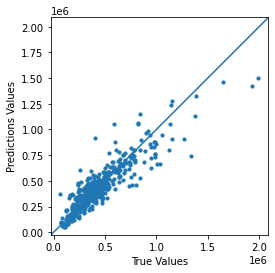

In [244]:
plt.scatter(y_test, predictions, cmap='red', s = 10)
plt.xlabel('True Values')
plt.ylabel('Predictions Values')
plt.axis('equal')
plt.axis('square')
droite = plt.plot([-10000000,10000000], [-10000000,10000000])

/home/yann/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='prix_achat'>

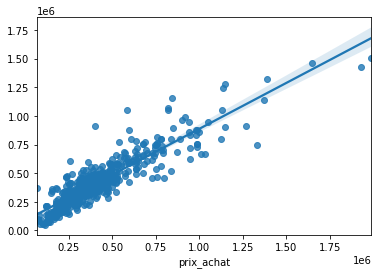

In [245]:
sns.regplot(y_test,predictions)

In [246]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:             prix_achat   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.808
Method:                 Least Squares   F-statistic:                     529.7
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:36:15   Log-Likelihood:                -18011.
No. Observations:                1381   AIC:                         3.605e+04
Df Residuals:                    1369   BIC:                         3.611e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2.668e+04    1.2e+04     

/home/yann/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [ ]:
tpot = TPOTRegressor(generations=50, population_size=20, verbosity=2, max_eval_time_mins=2, n_jobs=4)
tpot.fit(X_train, y_train)

In [ ]:
print(tpot.score(X_test, y_test))
tpot.export('tpot_torino_pipeline.py')

In [247]:
def build_model() :
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(pd.DataFrame(X_train).keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae','mse'])
    
    return model

In [248]:
model = build_model()

In [249]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                832       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________


In [250]:
class ShowModelProgression(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end="")

In [251]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10)

In [252]:
history = model.fit(
    X_train.astype(np.float32), y_train,
    epochs=10000, validation_split = 0.2, verbose = 0, callbacks=[early_stop, ShowModelProgression()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [253]:
len(history.epoch)

1436

In [254]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG] Mean Absolute')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
    plt.legend()
    plt.grid(True)
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG] Mean Square')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
    plt.legend()
    plt.grid(True)

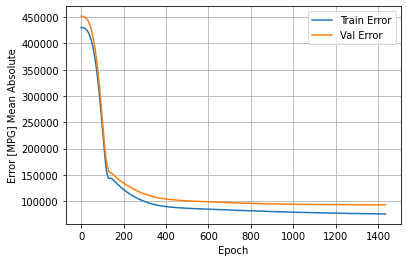

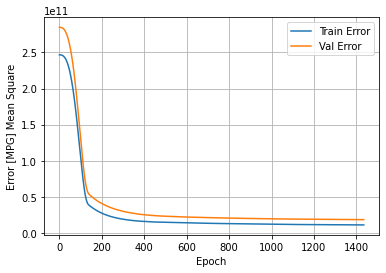

In [255]:
plot_history(history)

In [256]:
loss, mae, mse = model.evaluate(X_test.astype(np.float32), y_test.astype(np.float32), verbose = 0)
print(f"Testing set Mean squared Error {mse}")

Testing set Mean squared Error 13442408448.0


In [257]:
test_predictions = model.predict(X_test.values.astype(np.float32)).flatten()

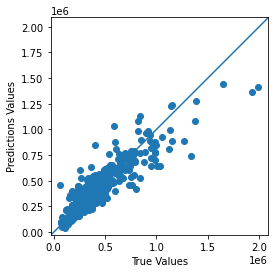

In [258]:
plt.scatter(y_test, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions Values')
plt.axis('equal')
plt.axis('square')
droite = plt.plot([-10000000,10000000], [-10000000,10000000])

### Sans la localisation

In [259]:
X = df.drop(['prix_achat', 'localisation'], axis=1)
Y = df['prix_achat']
X.shape, Y.shape


((1842, 2), (1842,))

In [260]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=16)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1381, 2)
(461, 2)
(1381,)
(461,)


In [261]:
model = linear_model.LinearRegression()
model.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [262]:
predictions = model.predict(X_test)

In [263]:
# print the intercept
print(model.intercept_)

22338.657171270344


The MSE d'enculé !!!

In [264]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, predictions))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, predictions))

Mean squared error: 16144907270.39
Coefficient of determination: 0.77


In [265]:
coeff_parameter = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_parameter

,Coefficient
nombre_chambres,-2.111150e+05
surface,1.553532e+06


In [266]:
predictions = model.predict(X_test)


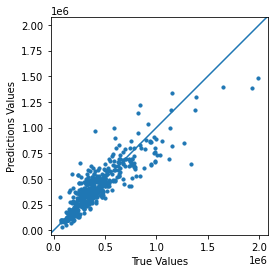

In [267]:
plt.scatter(y_test, predictions, cmap='red', s = 10)
plt.xlabel('True Values')
plt.ylabel('Predictions Values')
plt.axis('equal')
plt.axis('square')
droite = plt.plot([-10000000,10000000], [-10000000,10000000])

/home/yann/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='prix_achat'>

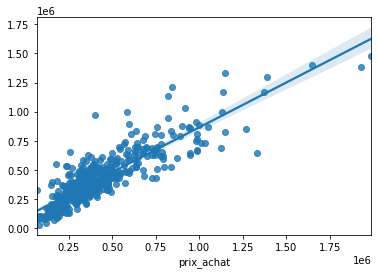

In [268]:
sns.regplot(y_test,predictions)

In [171]:
import statsmodels.api as sm
X_train_Sm= sm.add_constant(X_train)
X_train_Sm= sm.add_constant(X_train)
ls=sm.OLS(y_train,X_train_Sm).fit()
print(ls.summary())

                            OLS Regression Results                            
Dep. Variable:             prix_achat   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     2331.
Date:                Wed, 24 Mar 2021   Prob (F-statistic):               0.00
Time:                        01:25:57   Log-Likelihood:                -18136.
No. Observations:                1381   AIC:                         3.628e+04
Df Residuals:                    1378   BIC:                         3.629e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -8295.5327   7486.267     

/home/yann/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
